**1. Importing Necessary Libraries and preparing data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

In [ ]:
train_data = pd.read_csv("/content/Google_Stock_Price_Train.csv")
test_data = pd.read_csv("/content/Google_Stock_Price_Test.csv")

print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())

Training Data:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Testing Data:
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


In [ ]:
# Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())
print("\nMissing Values in Testing Data:")
print(test_data.isnull().sum())

# Clean numerical columns with string formatting issues
columns_to_clean = ['Open', 'High', 'Low', 'Close', 'Volume']
for column in columns_to_clean:
    if column in train_data.columns:
        train_data[column] = train_data[column].replace(',', '', regex=True).astype(float)
    if column in test_data.columns:
        test_data[column] = test_data[column].replace(',', '', regex=True).astype(float)

# Separate scaler for target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Close_scaled'] = target_scaler.fit_transform(train_data[['Close']])

# Scale the rest of the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data[columns_to_clean])

# Define N (past days) and M (future days) directly
N = 30  # Number of past days used for prediction
M = 1   # Number of future days to predict

# Create sequences
def create_sequences(data, n_steps, m_steps):
    X, y = [], []
    for i in range(len(data) - n_steps - m_steps + 1):
        X.append(data[i:i+n_steps, :-1])  # Use all features except the target
        y.append(data[i+n_steps:i+n_steps+m_steps, -1])  # Use only the target
    return np.array(X), np.array(y)

scaled_close = train_data[['Close_scaled']].to_numpy()
X, y = create_sequences(np.hstack((scaled_data, scaled_close)), N, M)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"\nTraining Set: {X_train.shape}, {y_train.shape}")
print(f"Validation Set: {X_val.shape}, {y_val.shape}")
print(f"Testing Set: {X_test.shape}, {y_test.shape}")


Missing Values in Training Data:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Missing Values in Testing Data:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Training Set: (982, 30, 5), (982, 1)
Validation Set: (123, 30, 5), (123, 1)
Testing Set: (123, 30, 5), (123, 1)


**Exploratory Data Analysis**

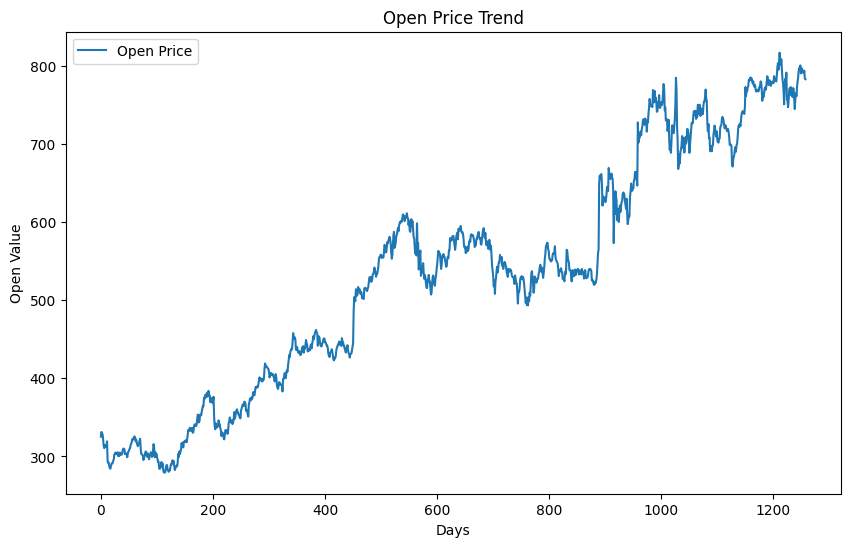

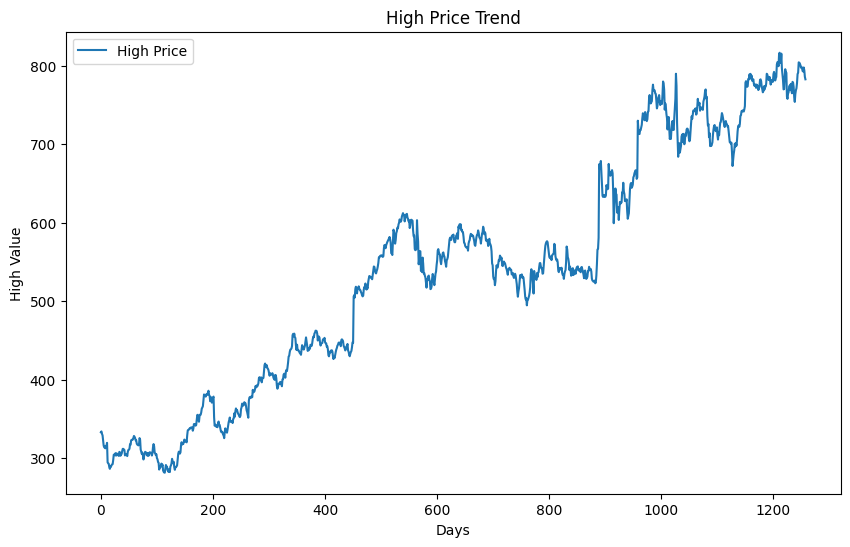

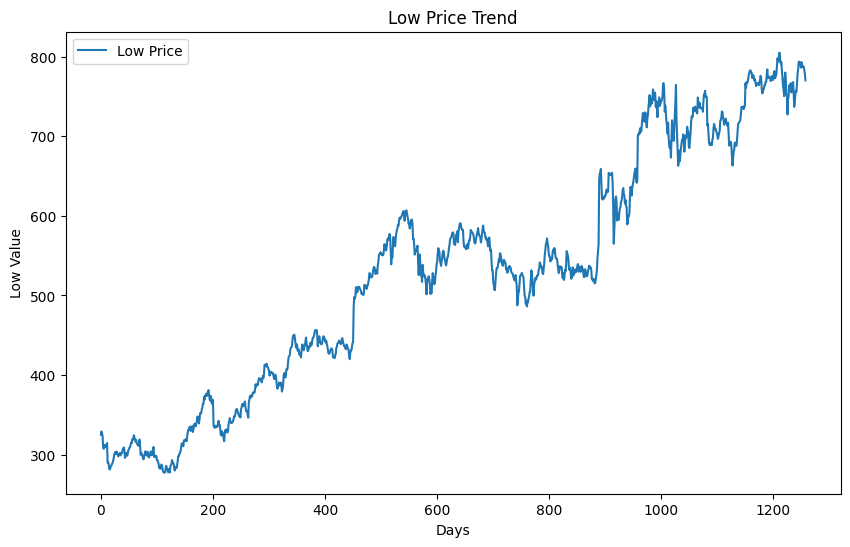

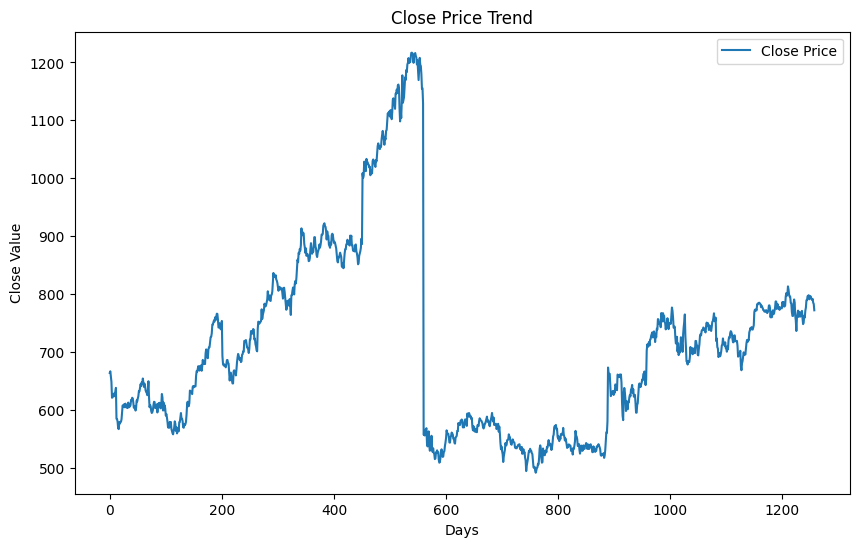

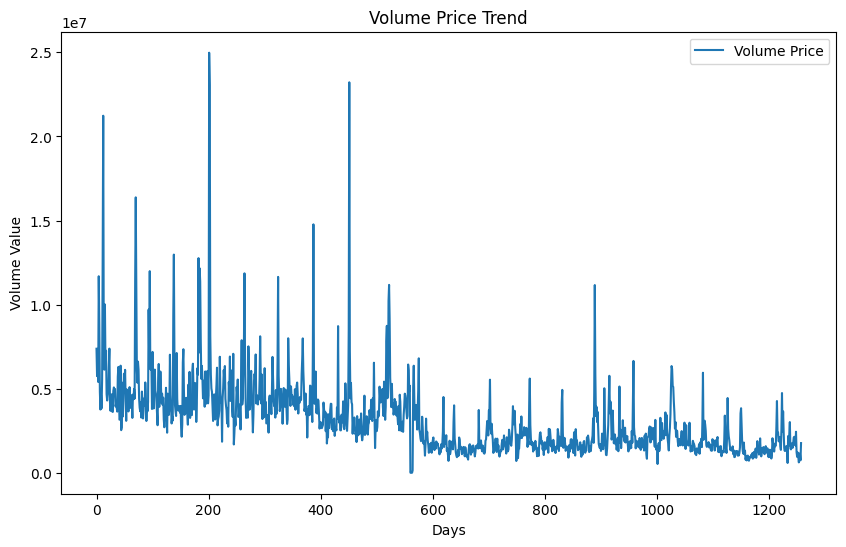

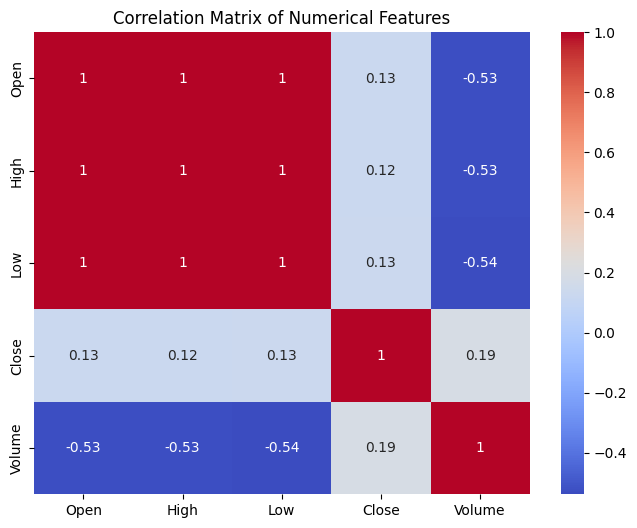

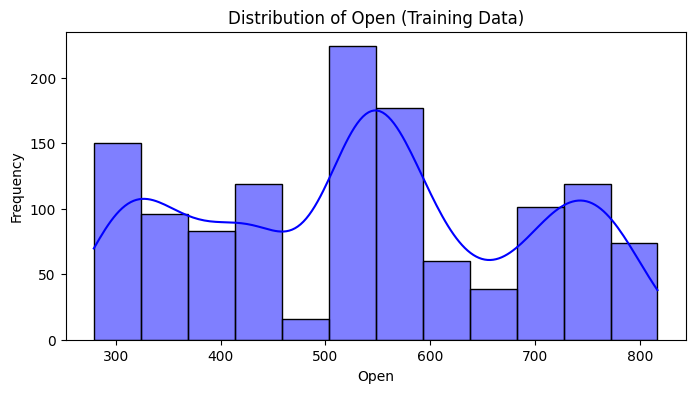

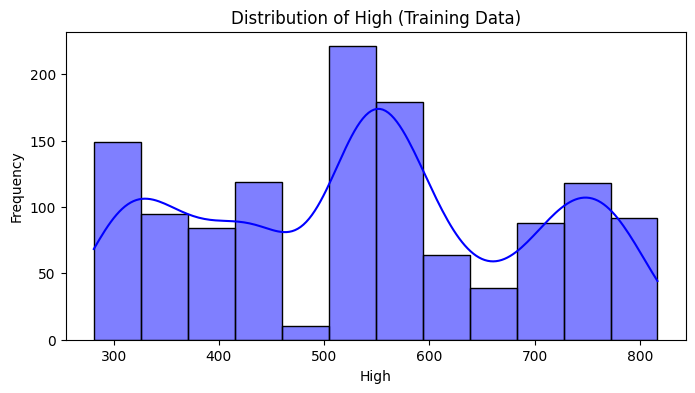

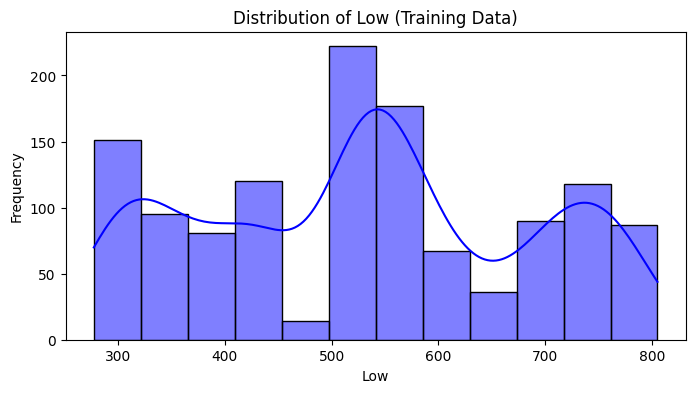

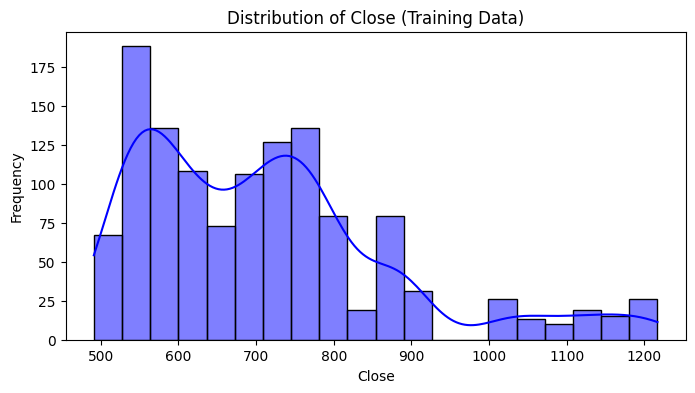

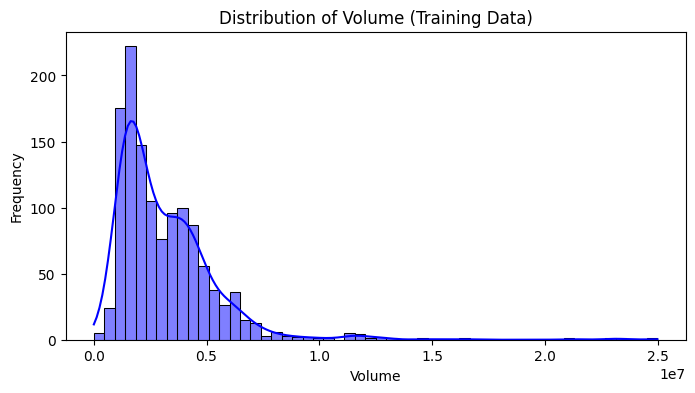

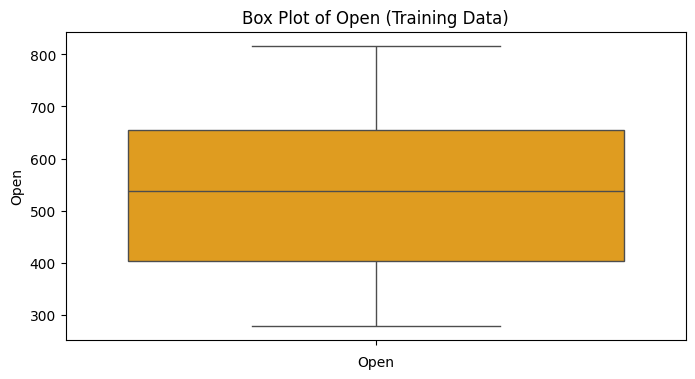

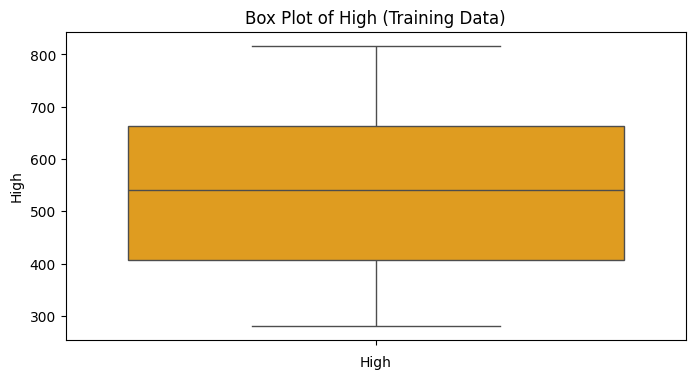

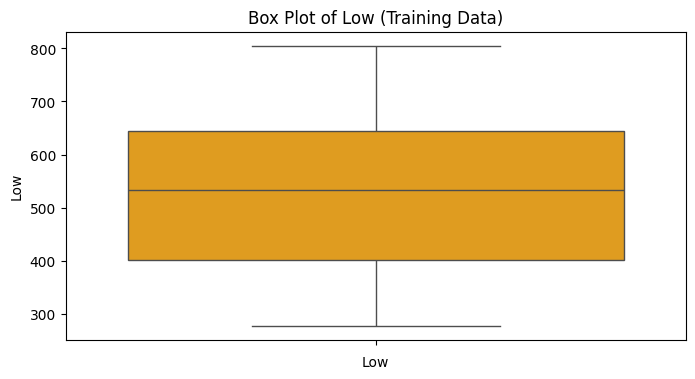

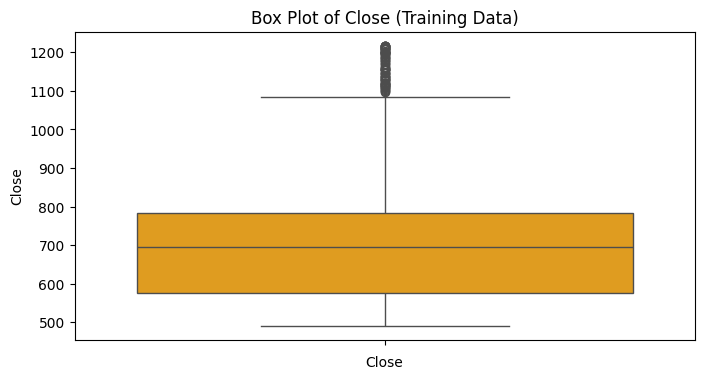

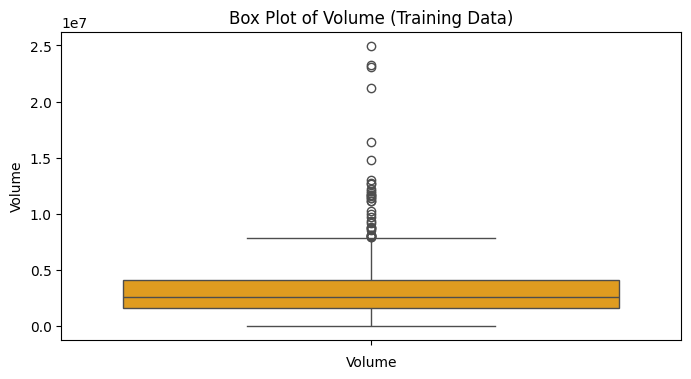

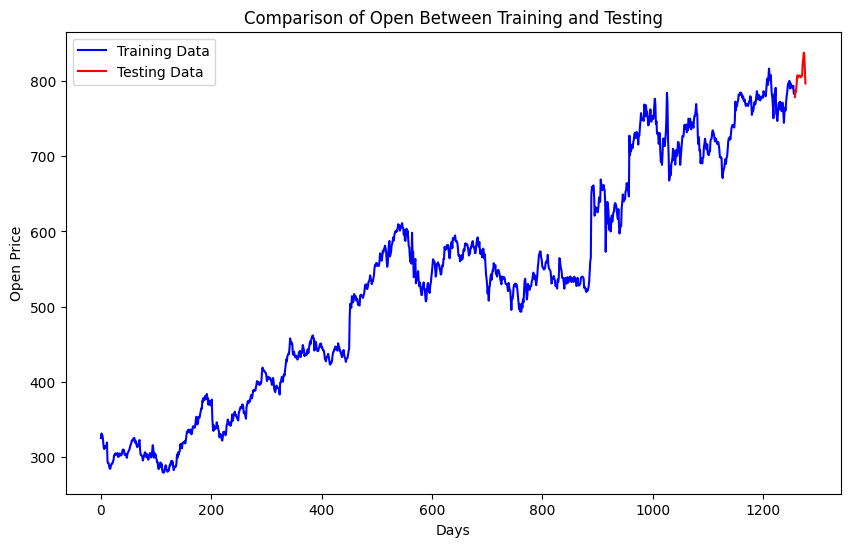

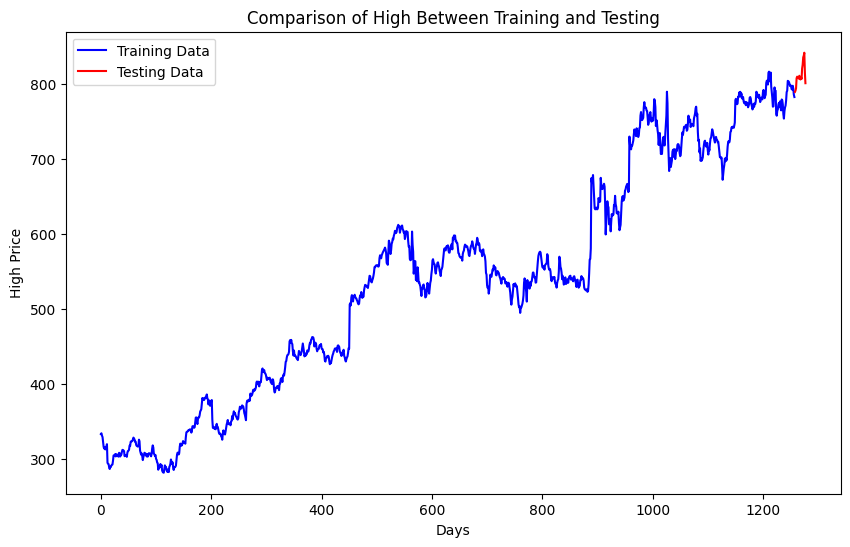

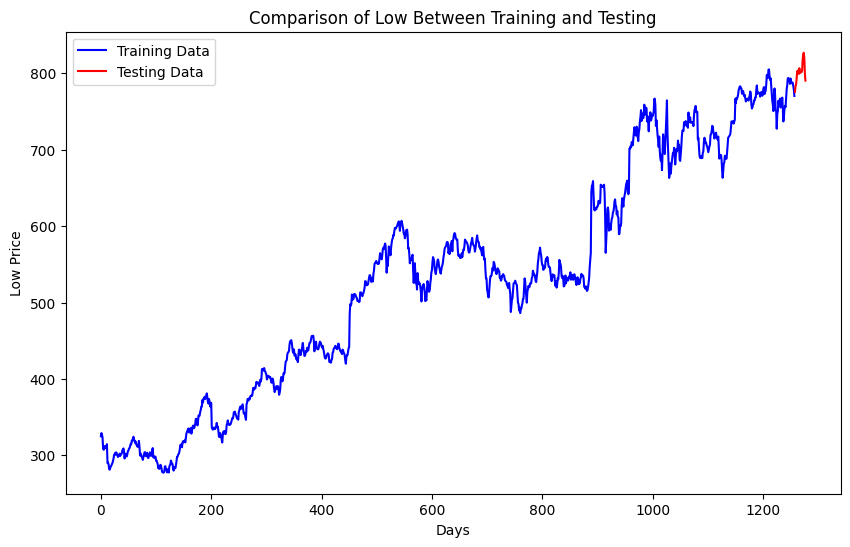

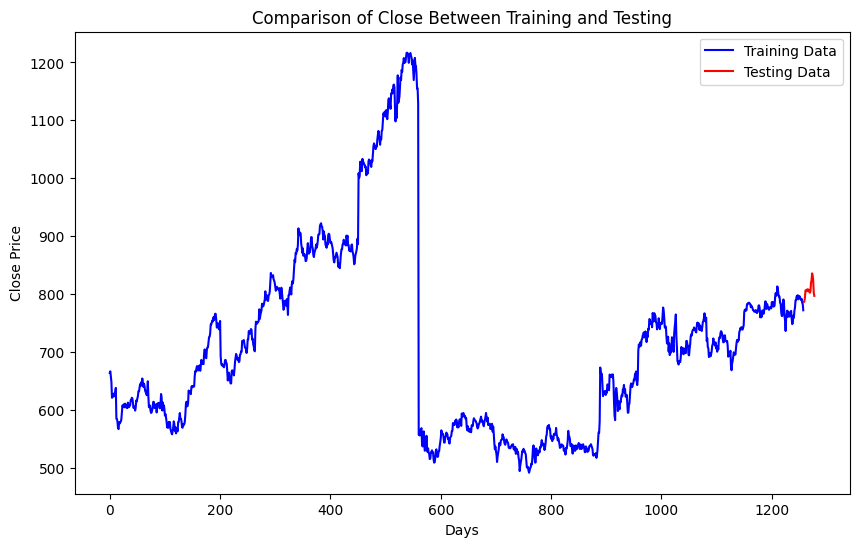

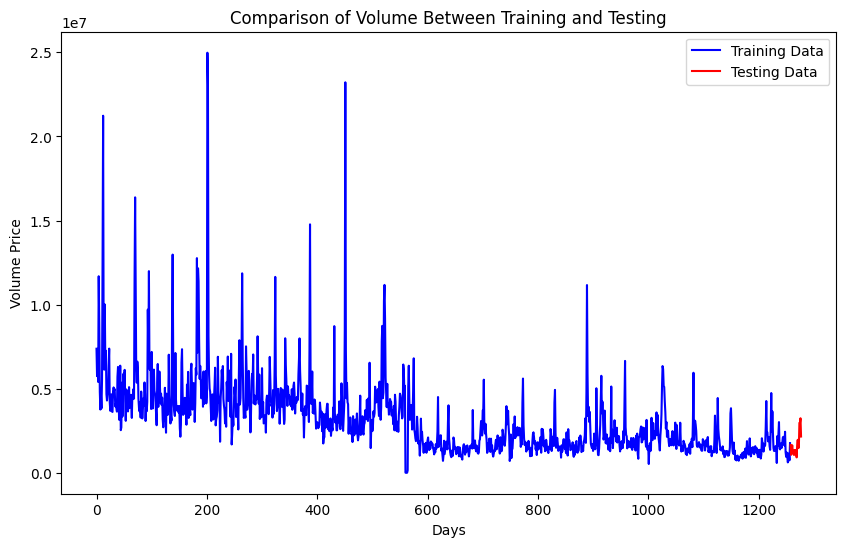

In [ ]:
# Visualizing trends for all numerical features in the training data
features = ['Open', 'High', 'Low', 'Close', 'Volume']
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data[feature], label=f'{feature} Price')
    plt.title(f'{feature} Price Trend')
    plt.xlabel('Days')
    plt.ylabel(f'{feature} Value')
    plt.legend()
    plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_data[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Distribution plots for all numerical features
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature} (Training Data)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Box plots for outlier detection
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(train_data[feature], color='orange')
    plt.title(f'Box Plot of {feature} (Training Data)')
    plt.xlabel(feature)
    plt.show()

# Comparison of feature trends in training and testing datasets
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data[feature], label='Training Data', color='blue')
    if feature in test_data.columns:
        plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data[feature], label='Testing Data', color='red')
    plt.title(f'Comparison of {feature} Between Training and Testing')
    plt.xlabel('Days')
    plt.ylabel(f'{feature} Price')
    plt.legend()
    plt.show()


**Vanilla RNN-Baseline Model**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.4880 - mae: 0.5776 - val_loss: 0.0997 - val_mae: 0.2292
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1884 - mae: 0.3433 - val_loss: 0.0454 - val_mae: 0.1465
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1241 - mae: 0.2716 - val_loss: 0.0304 - val_mae: 0.1162
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1095 - mae: 0.2597 - val_loss: 0.0301 - val_mae: 0.1130
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0807 - mae: 0.2199 - val_loss: 0.0305 - val_mae: 0.1149
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0682 - mae: 0.1948 - val_loss: 0.0289 - val_mae: 0.1128
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0628 - mae: 0.1859 - val_loss: 0.0264 - val_mae: 0.1064
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0539 - mae: 0.1719 - val_loss: 0.0257 - val_mae: 0.1063
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0503 - mae: 0.1

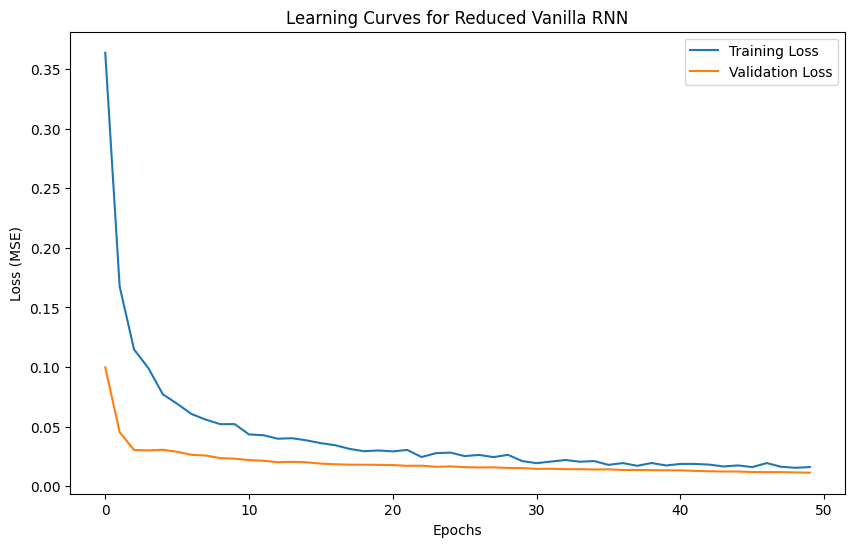

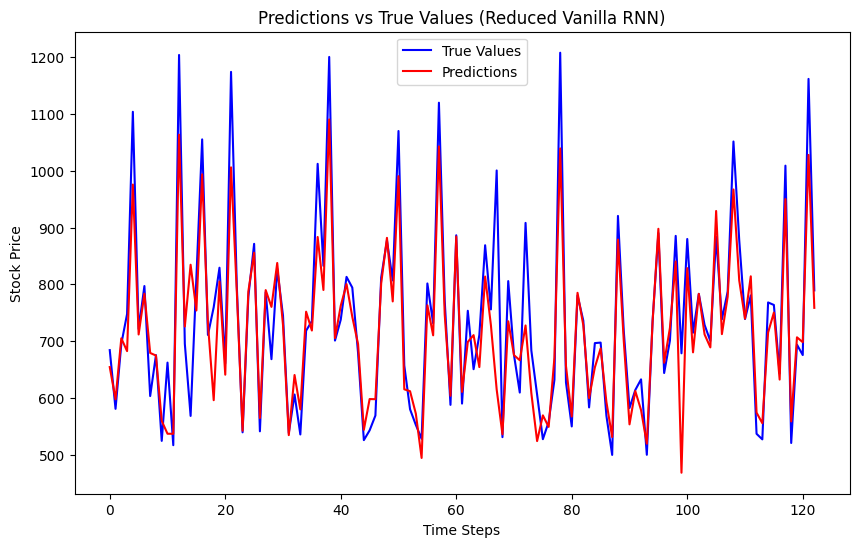

In [ ]:
# Define Reduced Vanilla RNN Model
def create_reduced_vanilla_rnn(input_shape):
    model = Sequential()
    # Add a single RNN layer with reduced units
    model.add(SimpleRNN(units=10, activation='tanh', input_shape=input_shape, return_sequences=False))  # Reduced units
    # Add a Dropout layer with higher rate
    model.add(Dropout(0.5))  # Increased dropout
    # Add a Dense layer for output
    model.add(Dense(units=M))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train the model
input_shape = (N, X_train.shape[2])  # Input shape for the RNN
vanilla_rnn_model = create_reduced_vanilla_rnn(input_shape)

history = vanilla_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,  # Batch size
    verbose=1
)

# Evaluate the model
test_loss, test_mae = vanilla_rnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict and inverse transform
predictions = vanilla_rnn_model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
accuracy = 1 - (np.abs(y_test_rescaled - predictions_rescaled) / y_test_rescaled)
accuracy = np.mean(accuracy) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves for Reduced Vanilla RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs True Values (Reduced Vanilla RNN)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**Vanilla RNN-Hyperparametric optimisation**

In [ ]:
pip install keras-tuner


Reloading Tuner from my_tuner_dir/vanilla_rnn_tuning/tuner0.json
Best number of units: 60
Best dropout rate: 0.30000000000000004
Best learning rate: 0.01
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - loss: 0.3504 - mae: 0.4580 - val_loss: 0.0207 - val_mae: 0.1158
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0467 - mae: 0.1621 - val_loss: 0.0047 - val_mae: 0.0572
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - mae: 0.0921 - val_loss: 0.0019 - val_mae: 0.0338
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0671 - val_loss: 0.0030 - val_mae: 0.0475
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - mae: 0.0594 - val_loss: 0.0018 - val_mae: 0.0361
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061 - mae: 0.0567 - val_loss: 6.6681e-04 - val_mae: 0.0183
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0054 - mae: 0.0497 - val_loss: 6.7944e-04 - val_mae: 0.0189
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - mae: 0.0469 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss:

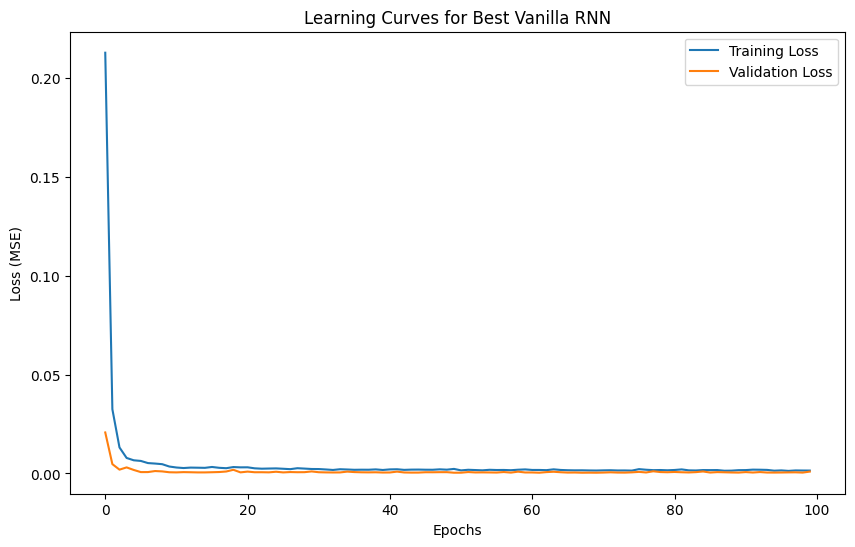

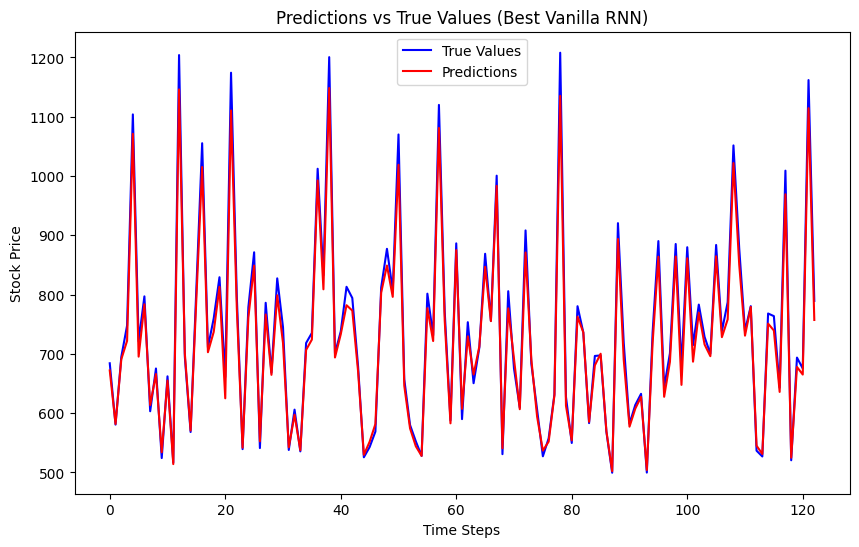

In [ ]:
# Define the hypermodel
def build_model(hp):
    model = Sequential()
    # Tune the number of units in the SimpleRNN layer
    model.add(SimpleRNN(
        units=hp.Int('units', min_value=10, max_value=100, step=10),  # Range: 10 to 100 with step 10
        activation='tanh',
        input_shape=(N, X_train.shape[2])
    ))
    # Tune the dropout rate
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))  # Range: 0.1 to 0.5
    # Output layer
    model.add(Dense(units=M))
    # Tune the learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',  # Optimize for validation loss
    max_trials=10,         # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Average results over 2 executions
    directory='my_tuner_dir',
    project_name='vanilla_rnn_tuning'
)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Number of epochs per trial
    batch_size=64  # Fixed batch size (can also be a hyperparameter)
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict and inverse transform
predictions = best_model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
accuracy = 1 - (np.abs(y_test_rescaled - predictions_rescaled) / y_test_rescaled)
accuracy = np.mean(accuracy) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves for Best Vanilla RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs True Values (Best Vanilla RNN)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**GRU- Baseline Model**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1731 - mae: 0.3079 - val_loss: 0.0111 - val_mae: 0.0859
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0999 - mae: 0.2364 - val_loss: 0.0115 - val_mae: 0.0850
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0682 - mae: 0.2001 - val_loss: 0.0072 - val_mae: 0.0692
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0484 - mae: 0.1684 - val_loss: 0.0058 - val_mae: 0.0614
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0355 - mae: 0.1430 - val_loss: 0.0045 - val_mae: 0.0536
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0285 - mae: 0.1298 - val_loss: 0.0034 - val_mae: 0.0458
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 - mae: 0.1116 - val_loss: 0.0025 - val_mae: 0.0391
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - mae: 0.1097 - val_loss: 0.0020 - val_mae: 0.0344
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - mae: 0.0947 - 

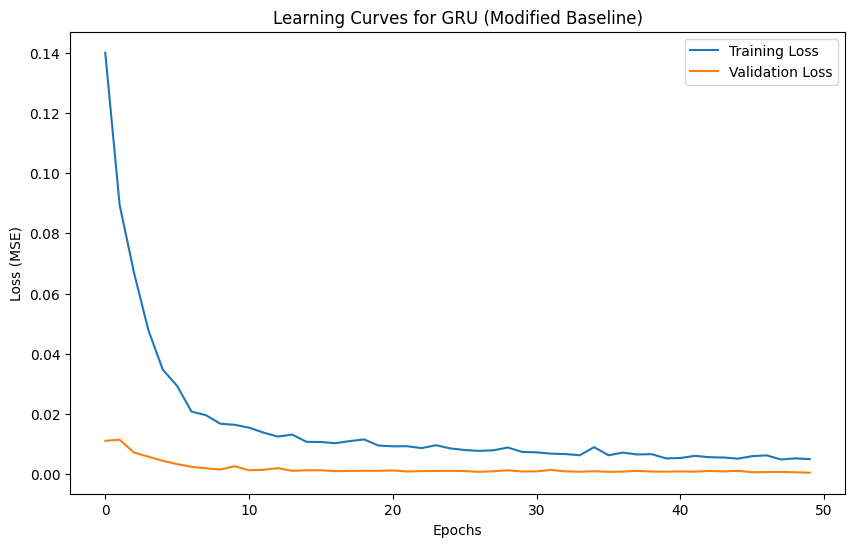

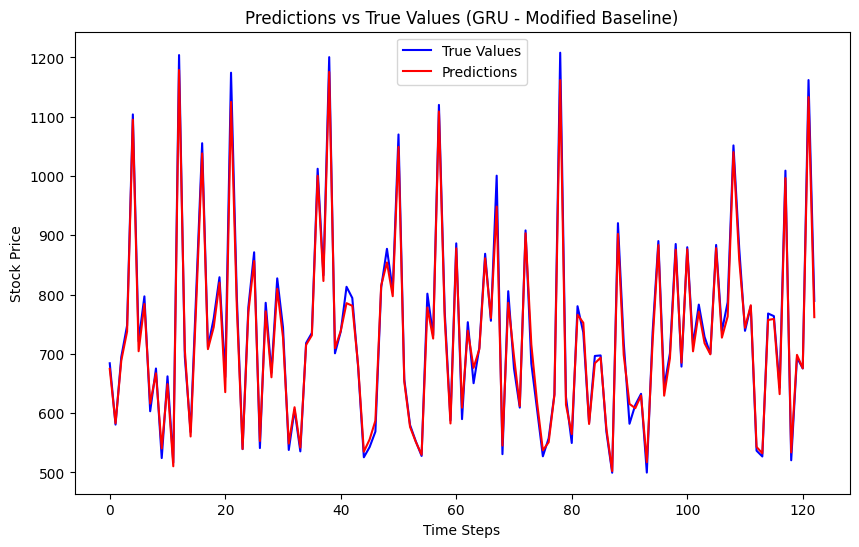

In [ ]:
# Define Modified GRU Baseline Model
def create_gru_model(input_shape):
    model = Sequential()
    # Add a single GRU layer with reduced units
    model.add(GRU(units=20, activation='tanh', input_shape=input_shape, return_sequences=False))  # Reduced units
    # Add a Dropout layer with higher rate
    model.add(Dropout(0.5))  # Increased dropout
    # Add a Dense layer for output
    model.add(Dense(units=M))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train the model
input_shape = (N, X_train.shape[2])  # Input shape for the GRU
gru_model = create_gru_model(input_shape)

# Train the GRU model with fewer epochs
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Reduced epochs
    batch_size=64,  # Batch size
    verbose=1  # Verbosity mode
)

# Evaluate the model on the test set
test_loss, test_mae = gru_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict and inverse transform
predictions = gru_model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
accuracy = 1 - (np.abs(y_test_rescaled - predictions_rescaled) / y_test_rescaled)
accuracy = np.mean(accuracy) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves for GRU (Modified Baseline)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs True Values (GRU - Modified Baseline)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**GRU- HYperparametric optimisation**

Reloading Tuner from gru_tuning_dir/gru_tuning/tuner0.json
Best number of units: 80
Best dropout rate: 0.2
Best learning rate: 0.001
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0672 - mae: 0.1969 - val_loss: 0.0086 - val_mae: 0.0747
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - mae: 0.0834 - val_loss: 0.0042 - val_mae: 0.0517
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mae: 0.0627 - val_loss: 0.0013 - val_mae: 0.0243
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mae: 0.0485 - val_loss: 0.0014 - val_mae: 0.0279
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - mae: 0.0450 - val_loss: 9.7728e-04 - val_mae: 0.0197
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0430 - val_loss: 0.0013 - val_mae: 0.0260
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0438 - val_loss: 7.6143e-04 - val_mae: 0.0174
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - mae: 0.0419 - val_loss: 8.0450e-04 - val_mae: 0.0193
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

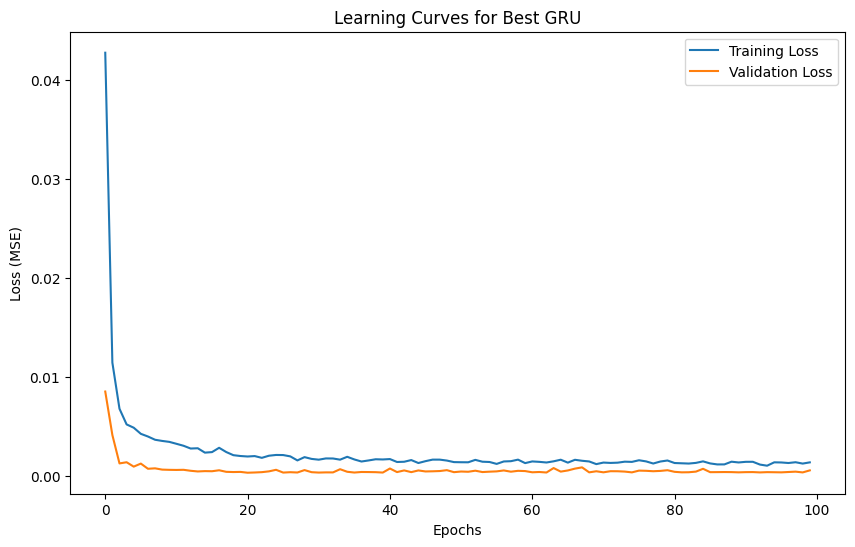

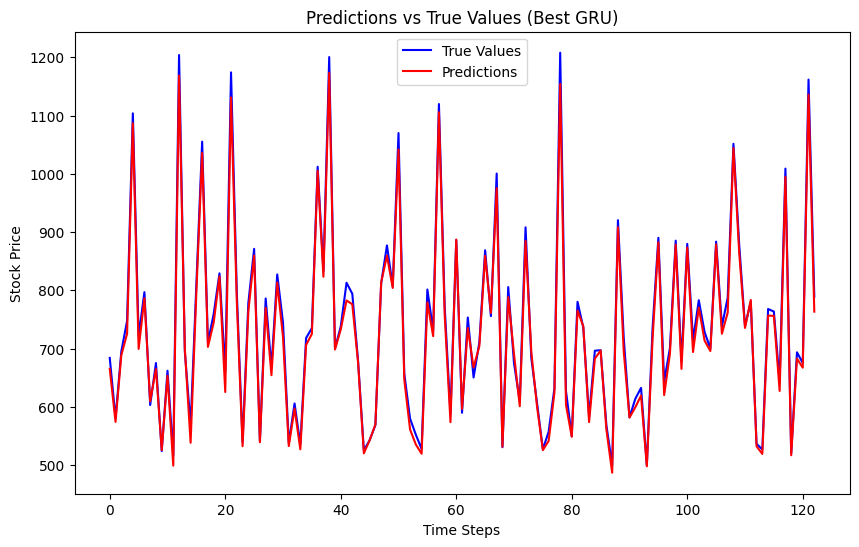

In [ ]:
# Define the hypermodel for GRU with adjustments to reduce accuracy
def build_gru_model(hp):
    model = Sequential()
    # Reduce the number of units to make the model simpler
    model.add(GRU(
        units=hp.Int('units', min_value=10, max_value=50, step=10),  # Reduced range for units
        activation='tanh',
        input_shape=(N, X_train.shape[2])
    ))
    # Increase the dropout rate to make the model underfit
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.4, max_value=0.7, step=0.1)))  # Increased dropout
    # Add the output layer
    model.add(Dense(units=M))
    # Use a higher learning rate to prevent optimal convergence
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),  # Increased learning rate
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    hypermodel=build_gru_model,
    objective='val_loss',  # Optimize for validation loss
    max_trials=10,         # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Average results over 2 executions
    directory='gru_tuning_dir',
    project_name='gru_tuning'
)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Use 100 epochs to give the model time to train, but still underfit
    batch_size=64,  # Fixed batch size
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_gru_model = tuner.hypermodel.build(best_hps)
history = best_gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Use 100 epochs to give the model time to train, but still underfit
    batch_size=64,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = best_gru_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict and inverse transform
predictions = best_gru_model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
accuracy = 1 - (np.abs(y_test_rescaled - predictions_rescaled) / y_test_rescaled)
accuracy = np.mean(accuracy) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves for Best GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs True Values (Best GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**LSTM-Baseline Model**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0594 - mae: 0.1811 - val_loss: 0.0092 - val_mae: 0.0706
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mae: 0.0793 - val_loss: 0.0062 - val_mae: 0.0437
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - mae: 0.0583 - val_loss: 0.0052 - val_mae: 0.0376
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - mae: 0.0618 - val_loss: 0.0051 - val_mae: 0.0325
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0549 - val_loss: 0.0051 - val_mae: 0.0338
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0522 - val_loss: 0.0048 - val_mae: 0.0355
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0485 - val_loss: 0.0044 - val_mae: 0.0327
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mae: 0.0456 - val_loss: 0.0039 - val_mae: 0.0309
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - mae: 0.0423 - v

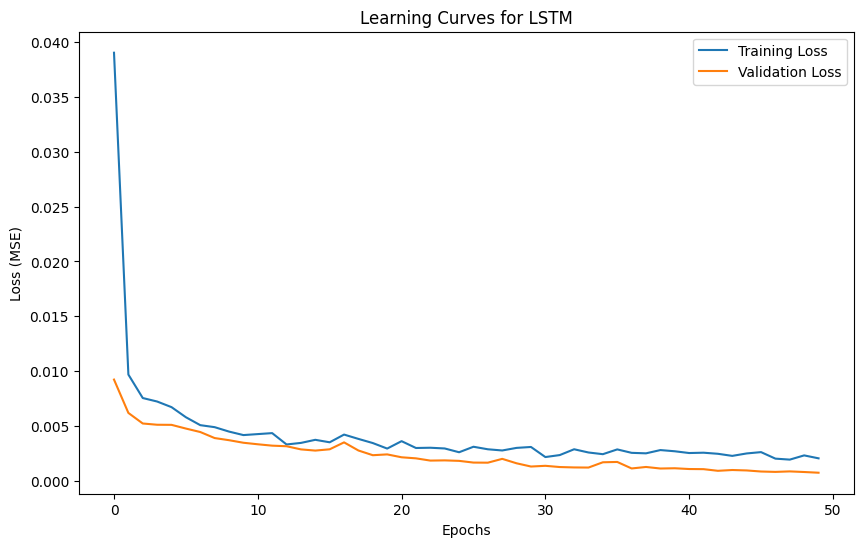

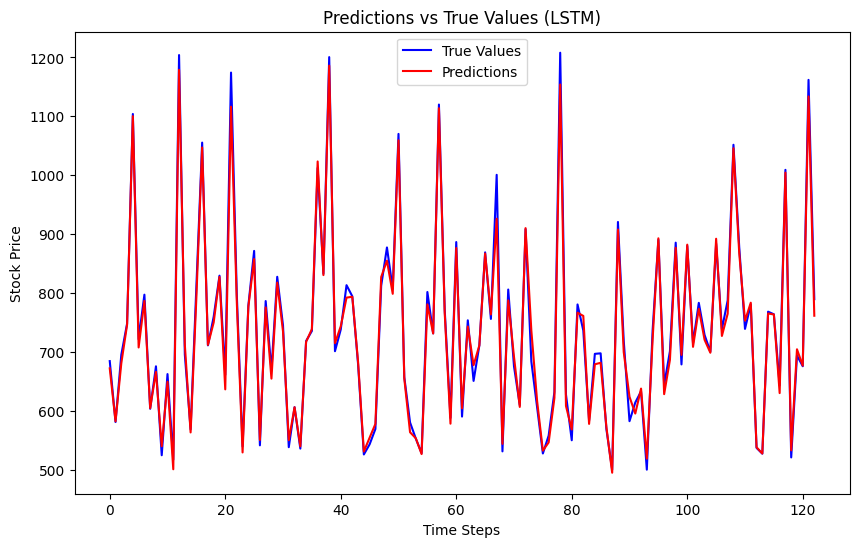

In [ ]:
# Define LSTM baseline model
def create_lstm_model(input_shape):
    model = Sequential()
    # Add a single LSTM layer
    model.add(LSTM(units=50, activation='tanh', input_shape=input_shape, return_sequences=False))
    # Add a Dropout layer for regularization
    model.add(Dropout(0.2))
    # Add a Dense layer for output
    model.add(Dense(units=M))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train the model
input_shape = (N, X_train.shape[2])  # Input shape for the LSTM
lstm_model = create_lstm_model(input_shape)

# Train the LSTM model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Number of epochs
    batch_size=64,  # Batch size
    verbose=1  # Verbosity mode
)

# Evaluate the model on the test set
test_loss, test_mae = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict and inverse transform
predictions = lstm_model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
accuracy = 1 - (np.abs(y_test_rescaled - predictions_rescaled) / y_test_rescaled)
accuracy = np.mean(accuracy) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs True Values (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**LSTM- Hyper paramteric Optimisation**

Reloading Tuner from lstm_tuning_dir/lstm_tuning/tuner0.json
Best number of units: 50
Best dropout rate: 0.1
Best learning rate: 0.01
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0801 - mae: 0.2108 - val_loss: 0.0058 - val_mae: 0.0515
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0512 - val_loss: 0.0031 - val_mae: 0.0294
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mae: 0.0355 - val_loss: 0.0022 - val_mae: 0.0238
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mae: 0.0256 - val_loss: 0.0021 - val_mae: 0.0261
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0274 - val_loss: 0.0018 - val_mae: 0.0266
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mae: 0.0323 - val_loss: 0.0013 - val_mae: 0.0206
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0308 - val_loss: 0.0011 - val_mae: 0.0193
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0255 - val_loss: 0.0021 - val_mae: 0.0349
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.

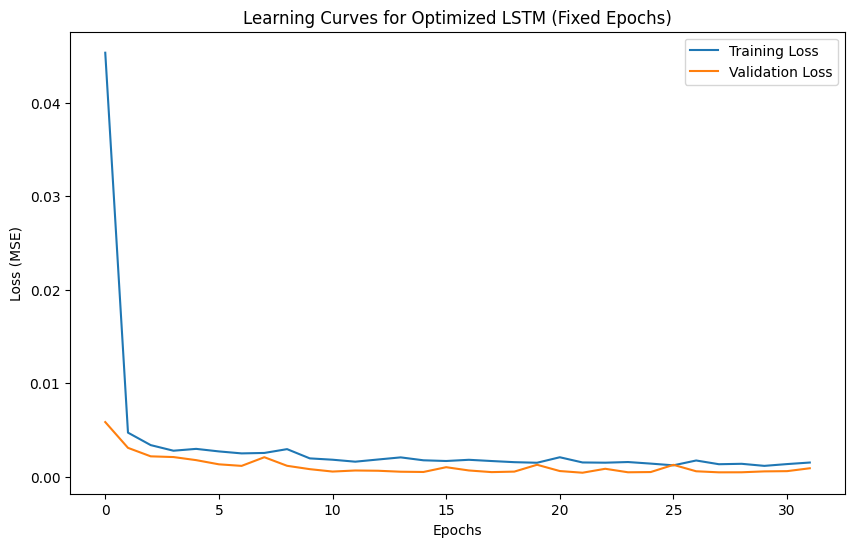

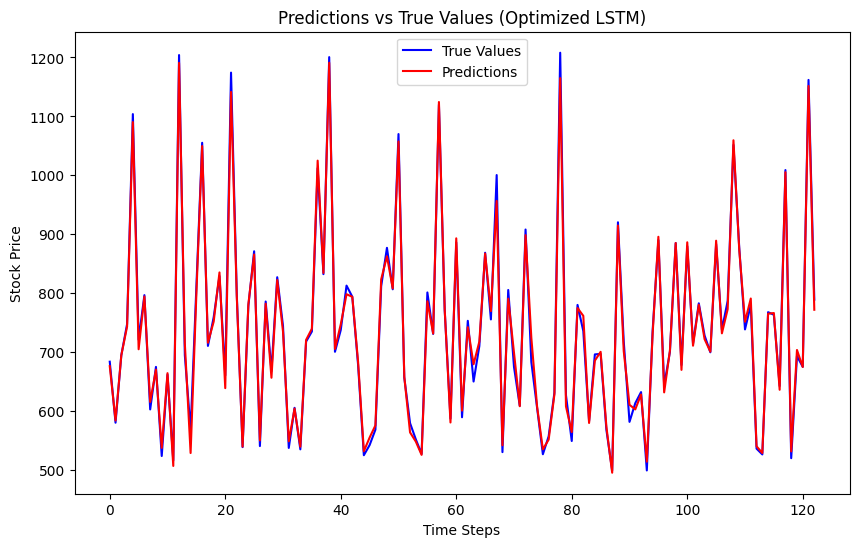

In [ ]:
# Define the hypermodel for LSTM with only a single LSTM layer
def build_lstm_model(hp):
    model = Sequential()
    # Tune the number of units in the single LSTM layer
    model.add(LSTM(
        units=hp.Int('units', min_value=100, max_value=200, step=50),  # Range for LSTM units
        activation='tanh',
        input_shape=(N, X_train.shape[2]),
        return_sequences=False  # Single LSTM layer, no need for return_sequences=True
    ))
    # Add dropout for regularization
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    # Output layer
    model.add(Dense(units=M))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(
    hypermodel=build_lstm_model,
    objective='val_loss',  # Optimize for validation loss
    max_trials=10,         # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Average results over 2 executions
    directory='lstm_tuning_dir',
    project_name='lstm_tuning'
)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Keep the number of epochs fixed at 50
    batch_size=64,  # Fixed batch size
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_lstm_model = tuner.hypermodel.build(best_hps)

# Add early stopping and model checkpoint for better convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fix: Change the file format to .keras (recommended by Keras)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = best_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Fixed number of epochs
    batch_size=64,  # Fixed batch size
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]  # Use both early stopping and model checkpoint
)

# Evaluate the model on the test set
test_loss, test_mae = best_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict and inverse transform
predictions = best_lstm_model.predict(X_test)
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
accuracy = 1 - (np.abs(y_test_rescaled - predictions_rescaled) / y_test_rescaled)
accuracy = np.mean(accuracy) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves for Optimized LSTM (Fixed Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs True Values (Optimized LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
